# Quantitative Trading Strategies in Python: From Simple to Advanced

This notebook demonstrates three trading strategies using Python, progressing from basic to more advanced methods:

1. Simple Moving Average (SMA) Crossover
2. RSI + SMA Combination Strategy
3. Polynomial Regression Bands Strategy

Each strategy uses real historical stock data (AAPL), is implemented with `backtrader`, and includes backtesting and plotting.

---

## Step 1: Import Libraries

In [1]:
!pip install -q yfinance pandas backtrader matplotlib scikit-learn mplfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 5.1 MB/s eta 0:00:00


In [2]:
%matplotlib inline

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
import backtrader as bt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import mplfinance as mpf

## Step 2: Download Historical Stock Data

In [3]:
symbol = 'AAPL'
start_date = '2020-01-01'
end_date = '2023-12-31'

data = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
data.dropna(inplace=True)
data.columns = ['open', 'high', 'low', 'close', 'volume']
data.head()

/tmp/ipython-input-3-3344925519.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(symbol, start=start_date, end=end_date)[['Open', 'High', 'Low', 'Close', 'Volume']]
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2020-01-02,71.627084,72.681281,71.373211,72.620834,135480400
2020-01-03,71.847110,72.676439,71.689950,71.914810,146322800
2020-01-06,71.034694,72.526518,70.783234,72.487831,118387200
2020-01-07,72.497522,72.753816,71.926907,72.146935,108872000
2020-01-08,71.849540,73.609752,71.849540,73.307518,132079200


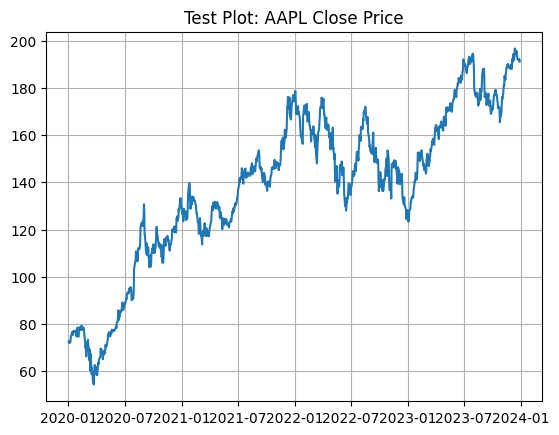

In [4]:
plt.plot(data['close'])
plt.title('Test Plot: AAPL Close Price')
plt.grid(True)
plt.show()

## Strategy 1: Simple Moving Average Crossover

In [5]:
class SmaCross(bt.SignalStrategy):
    def __init__(self):
        sma1 = bt.ind.SMA(period=20)
        sma2 = bt.ind.SMA(period=50)
        self.signal_add(bt.SIGNAL_LONG, bt.ind.CrossOver(sma1, sma2))

## Strategy 2: RSI + SMA Combo

In [6]:
class RsiSma(bt.Strategy):
    def __init__(self):
        self.rsi = bt.ind.RSI(period=14)
        self.sma = bt.ind.SMA(period=50)

    def next(self):
        if not self.position and self.rsi < 30 and self.data.close[0] > self.sma:
            self.buy()
        elif self.rsi > 70 or self.data.close[0] < self.sma:
            self.close()

## Strategy 3: Polynomial Regression Bands

In [7]:
class PolyBand(bt.Strategy):
    def __init__(self):
        self.poly_fit_window = 20
        self.degree = 2

    def next(self):
        if len(self.data) < self.poly_fit_window:
            return

        y = np.array([self.data.close[-i] for i in range(self.poly_fit_window)][::-1])
        x = np.arange(len(y)).reshape(-1, 1)

        poly = PolynomialFeatures(degree=self.degree)
        X_poly = poly.fit_transform(x)
        model = LinearRegression().fit(X_poly, y)
        pred = model.predict(X_poly)

        upper = pred + 2 * np.std(y - pred)
        lower = pred - 2 * np.std(y - pred)

        current_price = self.data.close[0]
        if not self.position and current_price < lower[-1]:
            self.buy()
        elif self.position and current_price > upper[-1]:
            self.close()

## Backtesting Function

In [8]:
class PandasData(bt.feeds.PandasData):
    params = (
        ('datetime', None),
        ('open', 'open'),
        ('high', 'high'),
        ('low', 'low'),
        ('close', 'close'),
        ('volume', 'volume'),
        ('openinterest', -1),
    )


In [9]:
def run_backtest(strategy_class, cash=10000):
    cerebro = bt.Cerebro()
    cerebro.addstrategy(strategy_class)
    datafeed = PandasData(dataname=data)
    cerebro.adddata(datafeed)
    cerebro.broker.set_cash(cash)
    cerebro.run()

    portfolio_value = cerebro.broker.getvalue()
    start_cash = 10000
    profit = portfolio_value - start_cash
    return_pct = (profit / start_cash) * 100

    print("🔍 Backtest Summary")
    print("-------------------------")
    print(f"💰 Final Portfolio Value: ${portfolio_value:,.2f}")
    print(f"📈 Total Profit: ${profit:,.2f}")
    print(f"📊 Return: {return_pct:.2f}%")
    print(f"🧠 Strategy: {strategy_class.__name__}")

    figs = cerebro.plot(style='candlestick', iplot=False)
    fig = figs[0][0]
    fig.savefig("bt_plot.png")

    Image("bt_plot.png")

## Run a Strategy

🔍 Backtest Summary
-------------------------
💰 Final Portfolio Value: $10,062.86
📈 Total Profit: $62.86
📊 Return: 0.63%
🧠 Strategy: SmaCross


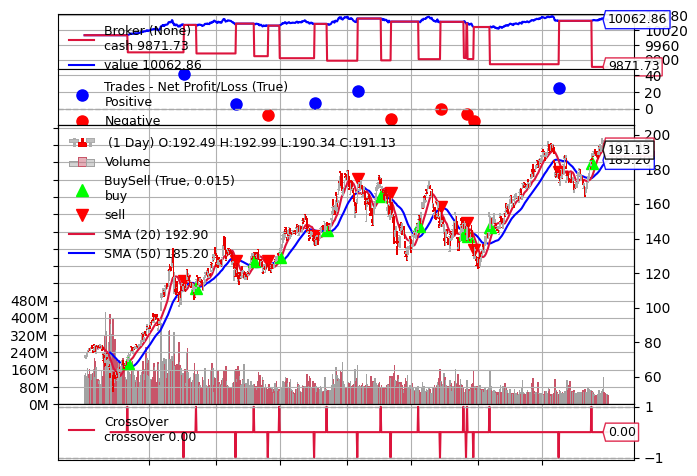

In [10]:
# Choose one of the strategies to test:
# run_backtest(SmaCross)
# run_backtest(RsiSma)
# run_backtest(PolyBand)

run_backtest(SmaCross)

---
### Conclusion
This notebook showed how to implement and backtest three trading strategies in Python:
- A simple trend-following SMA crossover
- A momentum-based RSI + trend filter
- An advanced mean-reversion method using Polynomial Regression Bands

You can further extend this by optimizing parameters, adding position sizing, or testing on other assets.

Happy trading! 🚀


**Explore the full article on Medium for explanations, visuals, and strategy comparisons.**
